### HMMs using Kalman filter in Stan. 

* Code from https://jrnold.github.io/ssmodels-in-stan/the-linear-state-space-model.html

### Model

* $Y_t$ observation, $X_t$ latent factor, $Z_t$ covariates.

* 
\begin{align*}
Y_t 
& =
Z X_t + w_t, \quad w_t \sim N_3 \left (0, H(Z_t) \right ),
\\
X_t 
& =
T X_{t-1} + v_t, \quad v_t \sim N(0, I), 
\\
H(Z_t) 
& =
\text{diag}(\psi_1, \psi_2, \psi_3) + B Z_t Z_t^\top B^\top.
\end{align*}

In [1]:
# Calling libraries:
from __future__ import division
%matplotlib inline
import numpy as np, time, matplotlib.pyplot as plt, numpy.random as npr, pystan as ps, pickle, pandas
from pylab import plot, show, legend
from time import time
from scipy.stats import *
from tqdm import trange

In [2]:
sm = ps.StanModel(file="model_covariance_regression.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_986c1f041217e26476edc6423522f2f8 NOW.


#### Load data from file and define dimensions etc:

In [3]:
y = pandas.read_csv("/xtmp/DC-BATS_data/ozone_data/detrend_data.csv").values
data = pandas.read_csv("/xtmp/DC-BATS_data/ozone_data/data.csv").values

n = np.shape(y)[0]             # length of time series 
covariate = data[:,4::]

p = np.shape(y)[1]             # dimension of observations
s = np.shape(covariate)[1]     # dimension of covariates
m = 1                          # dimension of latent states

s1 = 1
Zero = np.zeros((n,s1))

### Plot data to visualize them:

In [4]:
for i in range(p) :
    y[:,i] /= (np.max(y[:,i]) - np.min(y[:,i]))

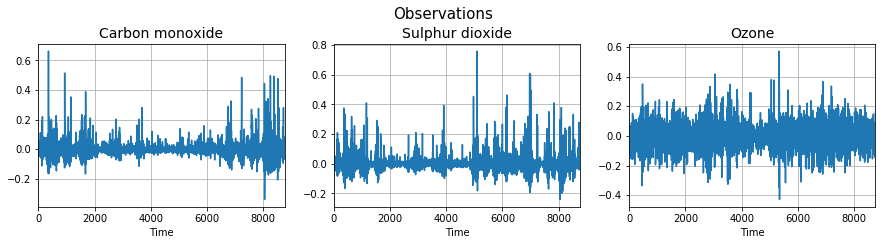

In [5]:
titles = ["Carbon monoxide", "Sulphur dioxide", "Ozone"]
plt.rcParams['figure.figsize'] = (15, 3)
for i in range(3) :
    plt.subplot(1,3,i+1)
    plt.plot(y[:,i])
    plt.grid(True)
    plt.xlabel("Time")
    plt.title(titles[i], fontsize=14)
    plt.xlim(0,n)
plt.suptitle("Observations", y=1.05, fontsize=15);

In [6]:
for i in range(2) :
    covariate[:,i] /= (np.max(covariate[:,i]) - np.min(covariate[:,i]))

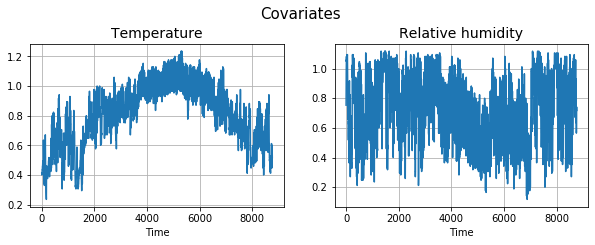

In [7]:
titles = ["Temperature", "Relative humidity"]
plt.rcParams['figure.figsize'] = (10, 3)
for i in range(s) :
    plt.subplot(1,s,i+1)
    plt.plot(covariate[:,i])
    plt.grid(True)
    plt.xlabel("Time")
    plt.title(titles[i], fontsize=14)
plt.suptitle("Covariates", y=1.05, fontsize=15);

### Divide-and-conquer:

In [8]:
K = 10
tstarts = np.arange(K).astype(int)
tends = 1 + tstarts
tstarts *= int(n/K)
tends *= int(n/K)

In [ ]:
n_chains = 10
for i in range(K) :
    tstart, tend = tstarts[i], tends[i]
    data = dict(n=tend-tstart, p=p, m=m, y=y[tstart:tend], s=s, covariate=covariate[tstart:tend], power=K)
    fit = sm.sampling(data=data, thin=1, n_jobs=min(10,n_chains), chains=n_chains, init="random", iter=1_000)
    file = open("/xtmp/DC-BATS_data/ozone_data/mcmc_wb_chunk"+str(i+1)+".pkl", "wb")
    pickle.dump(fit.extract(), file)
    file.close()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
  File "/home/postdoc/dsen/.local/lib/python3.6/site-packages/pystan/model.py", line 85, in _map_parallel
    map_result = pool.map(function, args)
  File "/auto/pkg/python-3.6/lib/python3.6/multiprocessing/pool.py", line 266, in map
    return self._map_async(func, iterable, mapstar, chunksize).get()
  File "/auto/pkg/python-3.6/lib/python3.6/multiprocessing/pool.py", line 638, in get
    self.wait(timeout)
  File "/auto/pkg/python-3.6/lib/python3.6/multiprocessing/pool.py", line 635, in wait
    self._event.wait(timeout)
  File "/auto/pkg/python-3.6/lib/python3.6/threading.py", line 551, in wait
    signaled = self._cond.wait(timeout)
  File "/auto/pkg/python-3.6/lib/python3.6/threading.py", line 295, in wait
    waiter.acquire()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/auto/pkg/python-3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 286

TypeError: must be str, not list

### Look at posterior samples:

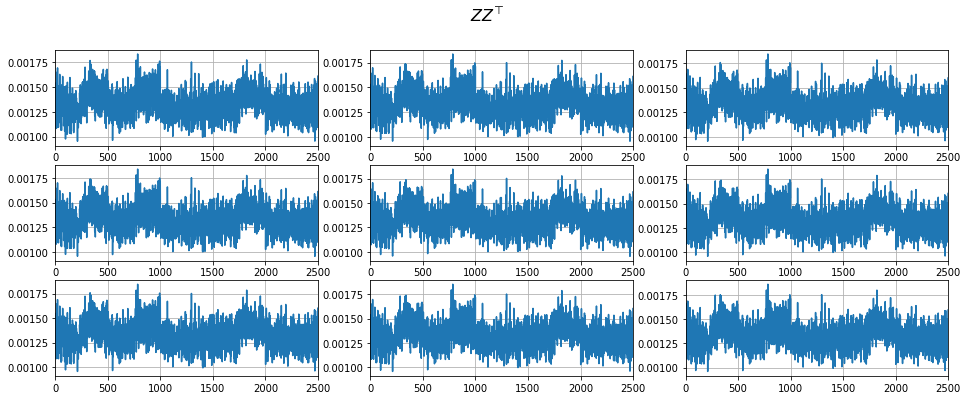

In [43]:
n_mcmc = np.shape(trace['Z'])[0]
ZZt = np.zeros((n_mcmc,p,p))
for i in range(n_mcmc) :
    ZZt[i] = trace['Z'][i].transpose().dot(trace['Z'][i])#/np.linalg.norm(trace['Z'][i])

plt.rcParams['figure.figsize'] = (16, 6)
for i in range(p) :
    for j in range(p) :
        idx = p*i+j+1
        plt.subplot(p,p,idx)
        plt.plot(ZZt[:,i,j])
        plt.grid(True)
        plt.xlim(0,n_mcmc)
plt.suptitle(r"$Z Z^\top$", fontsize=16);

In [36]:
np.shape(trace['Z'])

(2500, 1, 3)

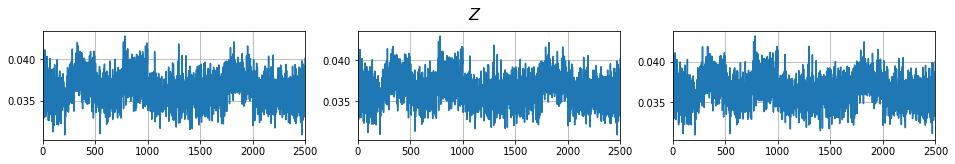

In [55]:
plt.rcParams['figure.figsize'] = (16, 2)
for i in range(p) :
    plt.subplot(1,p,i+1)
    plt.plot(np.abs(trace['Z'][:,0,i]))
#     plt.plot(trace['Z'][:,0,i])
    plt.grid(True)
    plt.xlim(0,n_mcmc)
plt.suptitle(r"$Z$", fontsize=16, y=1.05);

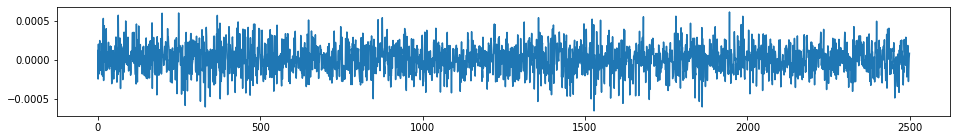

In [47]:
plt.plot(np.abs(trace['Z'][:,0,1])-np.abs(trace['Z'][:,0,0]))

In [39]:
np.shape(trace['B'])

(2500, 3, 2)

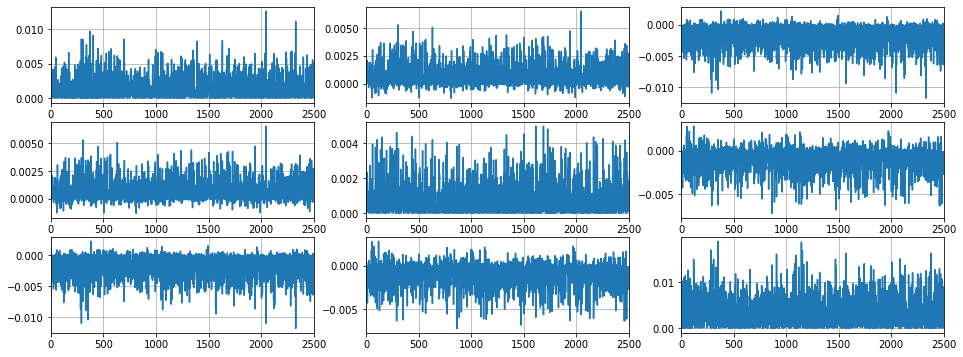

In [48]:
BBt = np.zeros((n_mcmc,p,p))
for i in range(n_mcmc) :
    BBt[i] = trace['B'][i].dot(trace['B'][i].transpose())#/np.linalg.norm(trace['B'][i])

plt.rcParams['figure.figsize'] = (16, 6)
for i in range(p) :
    for j in range(p) :
        idx = p*i+j+1
        plt.subplot(p,p,idx)
        plt.plot(BBt[:,i,j])
        plt.grid(True)
        plt.xlim(0,n_mcmc)

In [49]:
np.shape(trace['B'])

(2500, 3, 2)

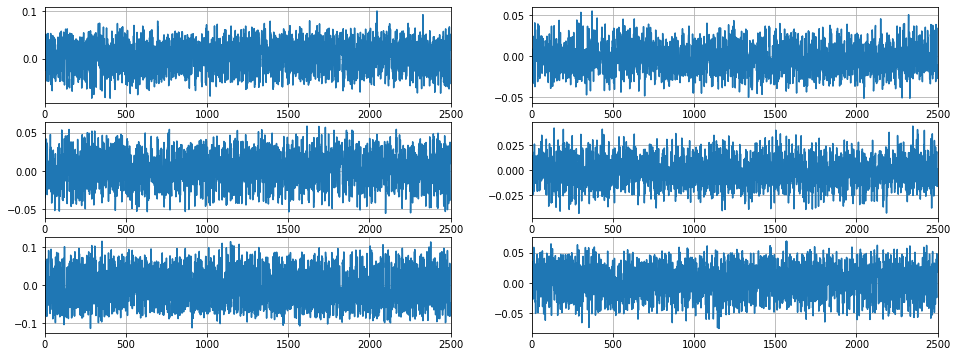

In [52]:
BBt = np.zeros((n_mcmc,p,p))

plt.rcParams['figure.figsize'] = (16, 6)
for i in range(p) :
    for j in range(s) :
        idx = s*i+j+1
        plt.subplot(p,s,idx)
        plt.plot(trace['B'][:,i,j])
        plt.grid(True)
        plt.xlim(0,n_mcmc)

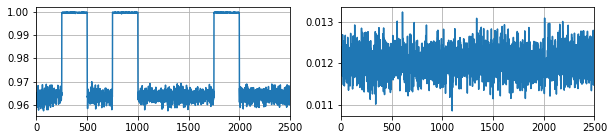

In [53]:
plt.rcParams['figure.figsize'] = (10, 2)
plt.subplot(121)
plt.plot(trace['Ttr'][:,0,0])
plt.xlim(0,n_mcmc)
plt.grid(True)
plt.subplot(122)
plt.plot(trace['psi'])
plt.grid(True)
plt.xlim(0,n_mcmc);

In [16]:
1

1